In [1]:
# Force garbage collection
import gc
gc.collect()

62

In [2]:
import os

In [3]:
import pandas as pd
import geopandas as gpd
import xarray as xr
import pyproj
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import precision_recall_curve,auc
import warnings
import pickle
from sklearn.metrics import confusion_matrix

In [4]:
# check python version and all packages version
def check_python_version():
    import sys
    print("Python version")
    print (sys.version)
    print("Pandas version")
    print(pd.__version__)
    print("Geopandas version")
    print(gpd.__version__)
    print("Xarray version")
    print(xr.__version__)
    print("Pyproj version")
    print(pyproj.__version__)

check_python_version()

Python version
3.11.9 | packaged by Anaconda, Inc. | (main, Apr 19 2024, 16:40:41) [MSC v.1916 64 bit (AMD64)]
Pandas version
2.2.2
Geopandas version
0.14.2
Xarray version
2023.6.0
Pyproj version
3.6.1


In [4]:
initial_features = ['dead_fuel_moisture_1000hr',
       'dead_fuel_moisture_100hr', 
       'max_air_temperature', 'max_relative_humidity', 
       #'max_wind_speed',
       'min_air_temperature', 'min_relative_humidity', 'precipitation_amount',
       'specific_humidity', 'surface_downwelling_shortwave_flux_in_air',
       #'wind_from_direction', 
       'wind_speed', 'wind_direction_category', 'SWE',
       'population_density_log',
       #'Band1', 
       'LAI', 'pdsi', 
       #'IS_FIRE', 
       #'NWCG_CAUSE_CLASSIFICATION',
       #'min_FIRE_SIZE', 'max_FIRE_SIZE', 'Year','veg_type_details','fire_attribute', 
       'veg', 
       #'slope_avg', 
       'slope_max',
       #'road_density_km_km2', 
       'road_density_km_km2_log'
       ]

In [5]:
def train_model(train_data, features, label_col):
    X_train = train_data[features]
    y_train = train_data[label_col]
    # train the model
    model = xgb.XGBClassifier(eval_metric='logloss', tree_method='hist')
    model.fit(X_train, y_train)
    return model

# define function to calculate precision and recall based on a threshold
def calculate_precision_recall(y_true, y_pred_proba, threshold, print_output=False):
    y_pred = (y_pred_proba > threshold).astype(int)
    confusion = confusion_matrix(y_true, y_pred)
    precision = confusion[1, 1] / (confusion[1, 1] + confusion[0, 1])
    recall = confusion[1, 1] / (confusion[1, 1] + confusion[1, 0])
    # F1 score
    f1 = 2 * (precision * recall) / (precision + recall)
    if print_output:
        print(f'Threshold: {threshold:.2f}')
        print(f'Precision: {precision * 100:.2f}%')
        print(f'Recall: {recall * 100:.2f}%')
        print("Confusion Matrix")
        print(pd.DataFrame(confusion, index=['True Neg', 'True Pos'], columns=['Pred Neg', 'Pred Pos']))
    # get TP, TN, FP, FN
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    return TP, TN, FP, FN, precision, recall, f1

def evaluate_model(model, test_data, features, label_col):
    X_test = test_data[features]
    y_test = test_data[label_col]
    # predict the probability of fire
    y_pred = model.predict_proba(X_test)[:, 1]
    # calculate the roc_auc_score
    roc_auc = roc_auc_score(y_test, y_pred)
    # print roc_auc in a sentence
    # print(f"ROC AUC: {roc_auc:.2f}")
    # Calculate precision and recall values
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    # Calculate the area under the precision-recall curve
    auc_pr = auc(recall, precision)
    # print(f"Area Under Precision-Recall Curve (AUC-PR): {auc_pr:.2f}")
    # calculate precision and recall at thresholds 0.5
    TP, TN, FP, FN, precision5, recall5, f15 = calculate_precision_recall(y_test, y_pred, 0.5)
    return roc_auc, auc_pr, TP, TN, FP, FN, precision5, recall5, f15

In [6]:
def get_water_year_range(target_year, num_years=6):
    min_year = target_year - num_years - 1
    min_day = f"{min_year}-10-01 00:00:00"
    max_day = f"{target_year-1}-09-30 00:00:00"
    return min_day, max_day

# Example: Get range for Water Year 2007
target_year = 2007
min_day, max_day = get_water_year_range(target_year)

print(f"Water Years {target_year - 6} to {target_year - 1}: {min_day} ~ {max_day}")

Water Years 2001 to 2006: 2000-10-01 00:00:00 ~ 2006-09-30 00:00:00


In [ ]:
results = []
log_messages = []
# add log to record the current time
log_messages.append(f"Start time: {pd.Timestamp.now()}")
# Define the range of years
years = range(2007, 2021)

# surpass the warning
warnings.filterwarnings("ignore")

mod_Human = pd.read_parquet(f'../Clean_Data/Model_Data/Downsample/Features_w_Label/features_w_label_downsample_completed_human_filter_veg_2001_2020.parquet')
# Check if the condition is met for any row in the mod_human DataFrame
if not ((mod_Human['NWCG_CAUSE_CLASSIFICATION'].str.contains('Human', na=False)) | (mod_Human['IS_FIRE'] == 0)).any():
    raise ValueError("No rows in mod_human meet the condition: 'Human' in NWCG_CAUSE_CLASSIFICATION or IS_FIRE == 0")

# Iterate over the years with a progress bar
for year in tqdm(years, desc="Processing years"):
    log_messages.append("-" * 50)
    # log current water year
    log_messages.append(f"Processing Water Year: {year}")
    # read eval data, prev-year Oct - current year Sep
    Eval_Human = pd.read_parquet(f'../Clean_Data/Model_Data/Evaluation/Features_w_Label/Human_Fire_Water_Year_Filter_Veg/{year}_features_w_label.parquet')

    # Check if the condition is met for any row in the Eval_human DataFrame
    if not ((Eval_Human['NWCG_CAUSE_CLASSIFICATION'].str.contains('Human', na=False)) | (Eval_Human['IS_FIRE'] == 0)).any():
        raise ValueError("No rows in Eval_human meet the condition: 'Human' in NWCG_CAUSE_CLASSIFICATION or IS_FIRE == 0")
   
    # get water year range
    min_day, max_day = get_water_year_range(year)
    # filter the training data
    train_data = mod_Human[(mod_Human['day'] >= min_day) & (mod_Human['day'] <= max_day)]
    # use log message to show the min and max of day from mod_Human
    log_messages.append(f"Training Data Day min: {train_data['day'].min()}, max: {train_data['day'].max()}")
    #mod_Human = mod_Human[features_to_keep]
    #Eval_Human = Eval_Human[features_to_keep]

    cat_columns = ['wind_direction_category','veg']

    # one hot encoding
    train_data = pd.get_dummies(train_data, columns=cat_columns)
    Eval_Human = pd.get_dummies(Eval_Human, columns=cat_columns)

    # extract column names starting with 'wind_direction_category_' and 'veg_'
    wind_direction_category_cols = [col for col in train_data.columns if col.startswith('wind_direction_category_')]
    veg_cols = [col for col in train_data.columns if col.startswith('veg_') and col != 'veg_type_details']

    features = initial_features + wind_direction_category_cols + veg_cols
    # drop cat_columns from features
    features = [col for col in features if col not in cat_columns]

    label_col = 'IS_FIRE'
    model = train_model(train_data, features, label_col)
    # save model to a pickle file
    with open(f'../Model/6_water_year_completed_filter_veg/predict_{year}_6yr_model.pkl', 'wb') as f:
         pickle.dump(model, f)
    # save model to ../../Model/predict_year
    # model.save_model(f'../../Model/predict_{year}_6yr_model.json')
    # evaluate the model
    roc_auc, auc_pr, TP, TN, FP, FN, precision5, recall5, f15 = evaluate_model(model, Eval_Human, features, label_col)
    # append the results to the list
    results.append([year, roc_auc, auc_pr, TP, TN, FP, FN, precision5, recall5, f15])

    # add predictions to Eval_Human
    Eval_Human['predictions'] = model.predict_proba(Eval_Human[features])[:, 1]
    # save the predictions to a csv file
    Eval_Human.to_csv(f'../Clean_Data/Model_Data/Evaluation/Features_w_Label_w_pred/water_year_filter_veg/{year}_predictions.csv', index=False)

    # clean up the dataframes
    del train_data
    del Eval_Human

    # clean the cache
    gc.collect()

Processing years: 100%|██████████| 14/14 [1:10:56<00:00, 304.01s/it]


In [7]:
# save all csv to parquet
years = range(2007, 2021)

save_path = '../Clean_Data/Model_Data/Evaluation/Features_w_Label_w_pred/water_year_filter_veg_parquet'

if not os.path.exists(save_path):
    os.makedirs(save_path)

for year in tqdm(years, desc="Processing years"):
    # read the csv file
    df = pd.read_csv(f'../Clean_Data/Model_Data/Evaluation/Features_w_Label_w_pred/water_year_filter_veg/{year}_predictions.csv',
                            parse_dates=["day"],
                            dtype={"NWCG_CAUSE_CLASSIFICATION": "str",
                               "veg_type_details": "str",
                               "fire_attribute": "str"
                            })
    
    df.to_parquet(f'{save_path}/{year}_predictions.parquet', index=False)

    # clean up the dataframes
    del df
    # clean the cache
    gc.collect()

Processing years: 100%|██████████| 14/14 [19:59<00:00, 85.68s/it]


In [8]:
# Save the log messages to a log file
with open('../Logs/model_training_water_year_filter_veg_log.txt', 'w') as log_file:
    log_file.write('\n'.join(log_messages))

print("Log file saved to '../Logs/model_training_water_year_filter_veg_log.txt'")

Log file saved to '../Logs/model_training_water_year_filter_veg_log.txt'


In [9]:
# assign column names to the results
results_pd = pd.DataFrame(results, columns=['Year', 'ROC_AUC', 'AUC_PR', 'TP', 'TN', 'FP', 'FN', 'Precision_0.5', 'Recall_0.5', 'F1_0.5'])

In [10]:
results_pd

,Year,ROC_AUC,AUC_PR,TP,TN,FP,FN,Precision_0.5,Recall_0.5,F1_0.5
0,2007,0.868381,0.031078,97,5019022,87,5959,0.527174,0.016017,0.031090
1,2008,0.870765,0.018831,92,5027218,685,4985,0.118404,0.018121,0.031431
2,2009,0.882370,0.023806,82,5035408,322,3831,0.202970,0.020956,0.037989
3,2010,0.891106,0.014526,42,5051553,345,3340,0.108527,0.012419,0.022287
4,2011,0.894262,0.026879,85,5045727,200,3072,0.298246,0.026924,0.049390
5,2012,0.848330,0.017542,76,5040740,398,3356,0.160338,0.022145,0.038914
6,2013,0.862137,0.019334,74,5056588,325,3098,0.185464,0.023329,0.041445
7,2014,0.834882,0.016687,78,5077966,454,3204,0.146617,0.023766,0.040902
8,2015,0.855008,0.018630,76,5076441,354,2687,0.176744,0.027506,0.047604
9,2016,0.871084,0.028289,97,5086568,242,3071,0.286136,0.030619,0.055318


In [ ]:
# old one without filter
results_pd

,Year,ROC_AUC,AUC_PR,TP,TN,FP,FN,Precision_0.5,Recall_0.5,F1_0.5
0,2007,0.846991,0.023787,106,6163006,155,8836,0.406130,0.011854,0.023036
1,2008,0.864286,0.019267,116,6184038,718,7212,0.139089,0.015830,0.028424
2,2009,0.875439,0.021431,97,6192379,315,5695,0.235437,0.016747,0.031270
3,2010,0.888689,0.014167,40,6216381,241,4963,0.142349,0.007995,0.015140
4,2011,0.887757,0.020363,73,6210115,199,4405,0.268382,0.016302,0.030737
5,2012,0.833168,0.013598,72,6213501,444,4361,0.139535,0.016242,0.029097
6,2013,0.852016,0.017396,90,6239792,445,4021,0.168224,0.021892,0.038743
7,2014,0.820692,0.017404,85,6270337,386,3996,0.180467,0.020828,0.037346
8,2014,0.820692,0.017404,85,6270337,386,3996,0.180467,0.020828,0.037346
9,2015,0.845130,0.016631,71,6269898,156,3400,0.312775,0.020455,0.038399


In [ ]:
# old results before water year
results_pd

,Year,ROC_AUC,AUC_PR,TP,TN,FP,FN,Precision_0.5,Recall_0.5,F1_0.5
0,2007,0.851302,0.024120,90,6167366,100,8792,0.473684,0.010133,0.019841
1,2008,0.871330,0.019000,113,6186997,611,6804,0.156077,0.016337,0.029577
2,2009,0.876198,0.021575,91,6195834,303,5514,0.230964,0.016236,0.030338
3,2010,0.894652,0.015339,43,6219262,215,4794,0.166667,0.008890,0.016879
4,2011,0.875307,0.020267,87,6203993,209,4724,0.293919,0.018084,0.034071
5,2012,0.841820,0.014273,76,6205607,610,3970,0.110787,0.018784,0.032122
6,2013,0.840084,0.014179,94,6260533,620,4446,0.131653,0.020705,0.035782
7,2014,0.832412,0.018545,74,6273230,332,3468,0.182266,0.020892,0.037487
8,2015,0.844699,0.016563,68,6268283,160,3540,0.298246,0.018847,0.035454
9,2016,0.866443,0.023366,98,6268594,280,4147,0.259259,0.023086,0.042397


In [ ]:
# old results before log transform and remove slope_avg
results_pd

,Year,ROC_AUC,AUC_PR,TP,TN,FP,FN,Precision_0.5,Recall_0.5,F1_0.5
0,2007,0.853403,0.024742,114,6167270,196,8768,0.367742,0.012835,0.024804
1,2008,0.874382,0.021531,124,6186823,785,6793,0.136414,0.017927,0.031689
2,2009,0.880802,0.019929,96,6195846,291,5509,0.248062,0.017128,0.032043
3,2010,0.898411,0.016151,59,6219124,353,4778,0.143204,0.012198,0.022480
4,2011,0.877249,0.018264,77,6203920,282,4734,0.214485,0.016005,0.029787
5,2012,0.845066,0.015343,87,6205625,592,3959,0.128130,0.021503,0.036825
6,2013,0.844058,0.018143,97,6260596,557,4443,0.148318,0.021366,0.037351
7,2014,0.835510,0.015432,82,6272881,681,3460,0.107471,0.023151,0.038095
8,2015,0.848743,0.019787,87,6268244,199,3521,0.304196,0.024113,0.044684
9,2016,0.870779,0.022174,110,6268415,459,4135,0.193322,0.025913,0.045700


## Validate the prediction

In [11]:
import gc
gc.collect()

0

In [12]:
def validate_plot_adjust(threshold, year, plot=False):
    # Read eval data
    Evaluation_dat = pd.read_csv(f'../Clean_Data/Model_Data/Evaluation/Features_w_Label_w_pred/water_year_filter_veg/{year}_predictions.csv')

    # Convert 'day' to datetime if necessary
    if Evaluation_dat['day'].dtype != 'datetime64[ns]':
        Evaluation_dat['day'] = pd.to_datetime(Evaluation_dat['day'])

    # Extract month and assign binary predictions
    Evaluation_dat['month'] = Evaluation_dat['day'].dt.month
    Evaluation_dat['predictions_binary'] = (Evaluation_dat['predictions'] > threshold).astype(int)

    # Group data by month
    predicted_fires = Evaluation_dat.groupby('month')['predictions_binary'].sum()
    actual_fires = Evaluation_dat.groupby('month')['IS_FIRE'].sum()

    # Create figure and primary axis
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot predicted fires on primary y-axis
    ax1.plot(predicted_fires.index, predicted_fires, marker='o', label='Predicted Fires', color='darkblue')
    ax1.set_xlabel('Month')
    ax1.set_ylabel('Predicted Fires', color='darkblue')
    ax1.tick_params(axis='y', labelcolor='darkblue')

    # Create secondary y-axis
    ax2 = ax1.twinx()
    ax2.plot(actual_fires.index, actual_fires, marker='o', label='Actual Fires', color='orange')
    ax2.set_ylabel('Actual Fires', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')

    # Add title and legend
    plt.title(f'Predicted vs Actual Fires by Month (Threshold: {threshold})')
    fig.tight_layout()

    # Show or save plot
    if plot:
        plt.show()
    else:
        path = f'../Plot/Water_Year_Filter_Veg/Validate_Month/AdjustYAxis_{threshold}/Validation_Threshold_{threshold}_WaterYear_{year}.png'
        plt.savefig(path)
    
    plt.close()

In [13]:
def validate_plot(threshold, year, plot=False):
    # read eval data
    Evaluation_dat = pd.read_csv(f'../Clean_Data/Model_Data/Evaluation/Features_w_Label_w_pred/water_year_filter_veg/{year}_predictions.csv')
    # if dtype of day is not datetime64[ns], convert it to datetime64[ns]
    if Evaluation_dat['day'].dtype != 'datetime64[ns]':
        Evaluation_dat['day'] = pd.to_datetime(Evaluation_dat['day'])
    # get month from day
    Evaluation_dat['month'] = Evaluation_dat['day'].dt.month
    # assign predictions_binary to use threshold
    Evaluation_dat['predictions_binary'] = (Evaluation_dat['predictions'] > threshold).astype(int)
    predicted_fires = Evaluation_dat.groupby('month')['predictions_binary'].sum()
    actual_fires = Evaluation_dat.groupby('month')['IS_FIRE'].sum()

    # Plot the line chart
    plt.figure(figsize=(12, 6))
    # Plot predicted fires
    predicted_fires.plot(kind='line', marker='o', label='Predicted Fires')
    # Plot actual fires
    actual_fires.plot(kind='line', marker='o', label='Actual Fires')
    # Add titles and labels
    plt.title(f'Predicted vs Actual Fires by Month (Threshold: {threshold})')
    plt.xlabel('Month')
    plt.ylabel('Number of Fires')
    plt.legend()

    if plot:
        # Show the plot
        plt.show()
    else:
        # save the plot
        path = f'../Plot/Water_Year_Filter_Veg/Validate_Month/{threshold}/Validation_Threshold_{threshold}_WaterYear_{year}.png'
        plt.savefig(path)
    plt.close()

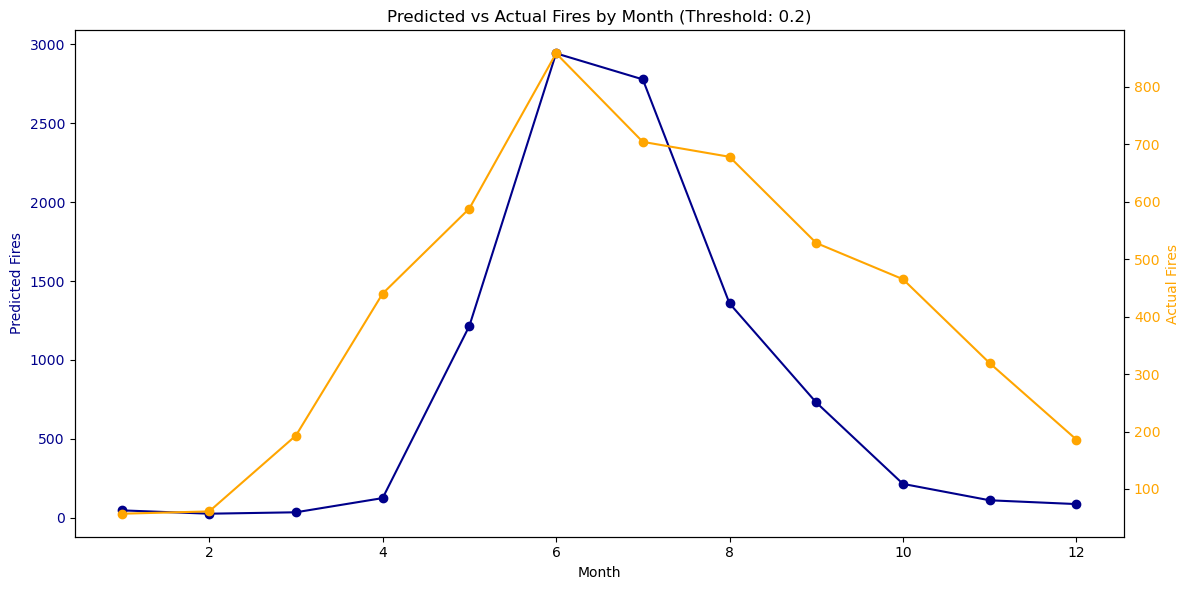

In [14]:
validate_plot_adjust(0.2, 2008, plot=True)

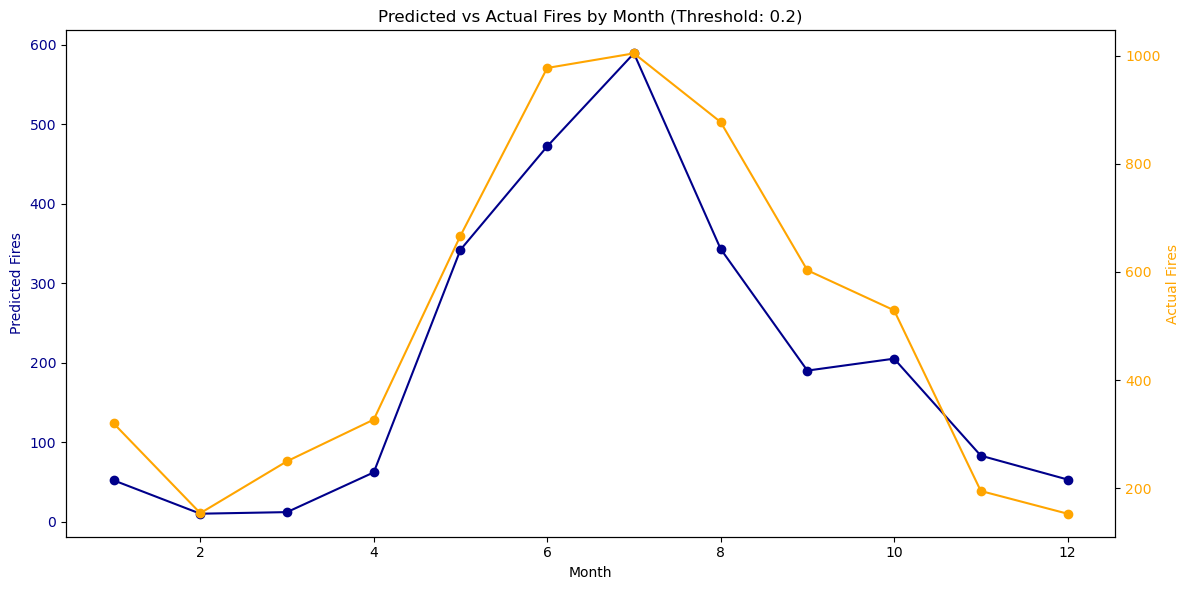

In [15]:
validate_plot_adjust(0.2, 2007, plot=True)

In [16]:
# disable the warning
warnings.filterwarnings("ignore")

In [17]:
years = range(2007, 2021)

for yr in tqdm(years, desc="Processing years"):
    validate_plot_adjust(0.2, yr)
    # clean the cache
    gc.collect()

Processing years: 100%|██████████| 14/14 [10:26<00:00, 44.72s/it]


In [18]:
years = range(2007, 2021)

for yr in tqdm(years, desc="Processing years"):
    validate_plot(0.2, yr)
    # clean the cache
    gc.collect()

Processing years: 100%|██████████| 14/14 [11:16<00:00, 48.33s/it]


In [19]:
# free up memory
gc.collect()
# check the memory usage

46536

In [20]:
log_messages = []
# add log to record the current time
log_messages.append(f"Start time: {pd.Timestamp.now()}")
# Define the range of years
years = range(2007, 2009)

# surpass the warning
warnings.filterwarnings("ignore")

mod_Human = pd.read_parquet(f'../Clean_Data/Model_Data/Downsample/Features_w_Label/features_w_label_downsample_completed_human_filter_veg_2001_2020.parquet')

# Iterate over the years with a progress bar
for year in tqdm(years, desc="Processing years"):
    log_messages.append("-" * 50)
    # log current water year
    log_messages.append(f"Processing Water Year: {year}")
    # read eval data, prev-year Oct - current year Sep
    Eval_Human = pd.read_parquet(f'../Clean_Data/Model_Data/Evaluation/Features_w_Label/Human_Fire_Water_Year_Filter_Veg/{year}_features_w_label.parquet')

    # Check if the condition is met for any row in the Eval_human DataFrame
    if not ((Eval_Human['NWCG_CAUSE_CLASSIFICATION'].str.contains('Human', na=False)) | (Eval_Human['IS_FIRE'] == 0)).any():
        raise ValueError("No rows in Eval_human meet the condition: 'Human' in NWCG_CAUSE_CLASSIFICATION or IS_FIRE == 0")
   
    # get water year range
    min_day, max_day = get_water_year_range(year)
    # filter the training data
    train_data = mod_Human[(mod_Human['day'] >= min_day) & (mod_Human['day'] <= max_day)]
    # use log message to show the min and max of day from mod_Human
    log_messages.append(f"Training Data Day min: {train_data['day'].min()}, max: {train_data['day'].max()}")

    # clean up the dataframes
    del train_data
    del Eval_Human

    # clean the cache
    gc.collect()

Processing years: 100%|██████████| 2/2 [00:08<00:00,  4.47s/it]


In [21]:
log_messages

['Start time: 2025-05-13 23:42:10.910729',
 '--------------------------------------------------',
 'Processing Water Year: 2007',
 'Training Data Day min: 2001-01-05 00:00:00, max: 2006-09-30 00:00:00',
 '--------------------------------------------------',
 'Processing Water Year: 2008',
 'Training Data Day min: 2001-10-01 00:00:00, max: 2007-09-30 00:00:00']